## Exploratory Analysis of the data

In [37]:
# Import Cleaned data
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

CLEANED_DATA_PATH = Path.cwd().parent / 'data' / 'dataset_mood_smartphone_cleaned.csv'



In [25]:
mood = pd.read_csv(CLEANED_DATA_PATH)

mood['time'] = pd.to_datetime(mood['time'], format='mixed',  errors='coerce')
# Add date column
mood['date'] = mood['time'].dt.date

mood

,Unnamed: 0,id,time,variable,value,time_since_last,hours_since_last,gap_category,avg_gap_hours,gap_std_hours,max_gap_hours,date
0,136471,AS14.01,2014-02-17 12:04:42.394,call,1.000,NaN,NaN,NaN,7.312217,35.008016,522.0,2014-02-17
1,136472,AS14.01,2014-02-17 18:28:25.520,call,1.000,0 days 06:23:43.126000,6.395313,normal,7.312217,35.008016,522.0,2014-02-17
2,136473,AS14.01,2014-02-18 09:29:51.257,call,1.000,0 days 15:01:25.737000,15.023816,12-24h,7.312217,35.008016,522.0,2014-02-18
3,136474,AS14.01,2014-02-19 14:43:30.575,call,1.000,1 days 05:13:39.318000,29.227588,24-48h,7.312217,35.008016,522.0,2014-02-19
4,136475,AS14.01,2014-02-19 17:29:10.378,call,1.000,0 days 02:45:39.803000,2.761056,normal,7.312217,35.008016,522.0,2014-02-19
...,...,...,...,...,...,...,...,...,...,...,...,...
363207,233404,AS14.33,2014-05-30 22:32:14.240,appCat.builtin,1.003,0 days 00:00:03.191000,0.000886,normal,5.821622,6.024007,55.0,2014-05-30
363208,233405,AS14.33,2014-05-30 22:32:15.246,appCat.builtin,4.134,0 days 00:00:01.006000,0.000279,normal,5.821622,6.024007,55.0,2014-05-30
363209,5641,AS14.33,2014-05-31 12:00:00.000,mood,7.000,0 days 16:00:00,16.000000,12-24h,5.821622,6.024007,55.0,2014-05-31
363210,11284,AS14.33,2014-05-31 12:00:00.000,circumplex.arousal,-2.000,0 days 16:00:00,16.000000,12-24h,5.821622,6.024007,55.0,2014-05-31


# Step 1 get daily data

In [26]:
# List with all unique users
user_ids = mood['id'].unique()
numeric_cols = mood.select_dtypes(include=['number']).columns

daily_mood = mood.pivot_table(
    values = 'value',
    index = ['id','date'],
    columns= 'variable',
    aggfunc='mean'
).reset_index()

daily_mood = daily_mood.sort_values(['id','date'])
daily_mood['mood_diff'] = daily_mood['mood'].diff()
daily_mood['date'] = pd.to_datetime(daily_mood['date'], errors='coerce')

def created_lagged_variables(df, variable: str, number_of_lags: int):
    for i in range(1, number_of_lags + 1):
        df[f'lag_{i}_{variable}'] = df.groupby('id')[variable].shift(i)
    return df

lagged_columns = (daily_mood.columns[daily_mood.columns.str.startswith('lag')])
lagged_columns = lagged_columns.to_list()

# Check results, seems to be valid
daily_mood[daily_mood['id'] == user_ids[1]][lagged_columns + ['id','date','mood']]

variable,id,date,mood
72,AS14.02,2014-02-17,NaN
73,AS14.02,2014-02-18,NaN
74,AS14.02,2014-02-19,NaN
75,AS14.02,2014-02-20,NaN
76,AS14.02,2014-02-21,NaN
...,...,...,...
135,AS14.02,2014-04-21,5.500000
136,AS14.02,2014-04-22,5.666667
137,AS14.02,2014-04-23,8.000000
138,AS14.02,2014-04-24,7.000000


### Lag analysis
Question to answer: How many lags to include in our model? Which lagged values determine today's mood?

#### Plotting functions

In [74]:
def plot_mean_pacf(df, ax=None):
    """
    Plot the mean partial-correlation function (PCCF) across all users on the given axis.
    """
    pacf_by_user = {}
    user_ids = df['id'].unique()
    for user_id in user_ids:
        user_mood = df[df['id'] == user_id]['mood'].dropna()
        pacf_values = pacf(user_mood, nlags=14, method='ywm')
        pacf_by_user[user_id] = pacf_values

    df_pacf_by_user = pd.DataFrame(pacf_by_user)
    mean_pacf = df_pacf_by_user.mean(axis=1)
    lags = np.arange(len(df_pacf_by_user))
    if ax is None:
        fig, ax = plt.subplots()
    ax.bar(lags, mean_pacf, alpha=0.7)
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Mean PACF')
    ax.set_title('Mean PACF (mood)')
    return ax
    
def plot_mean_ccf(daily_df, var1='mood', var2='activity', max_lag=14, ax=None):
    """
    Plot the mean cross-correlation function (CCF) between two variables across all users on the given axis.
    """
    from statsmodels.tsa.stattools import ccf
    user_ids = daily_df['id'].unique()
    ccf_list = []
    for user_id in user_ids:
        user_data = daily_df[daily_df['id'] == user_id].sort_values('date')
        s1 = user_data[var1].dropna()
        s2 = user_data[var2].dropna()
        min_len = min(len(s1), len(s2))
        if min_len > max_lag:
            ccf_vals = ccf(s1.iloc[:min_len], s2.iloc[:min_len])[:max_lag+1]
            ccf_list.append(ccf_vals)
    if not ccf_list:
        print(f"Not enough data to compute CCF for {var1} and {var2}.")
        return None
    ccf_arr = np.array(ccf_list)
    mean_ccf = ccf_arr.mean(axis=0)
    lags = np.arange(len(mean_ccf))
    if ax is None:
        fig, ax = plt.subplots()
    ax.bar(lags, mean_ccf, alpha=0.7)
    ax.set_xlabel('Lag')
    ax.set_ylabel(f'Mean CCF\n({var1}, {var2})')
    ax.set_ylim((-1, 1))
    ax.axhline(0, color='black', linestyle='--')
    ax.set_title(f'{var1} vs {var2}')
    return ax

## Plotting the PACF and the CCF per user

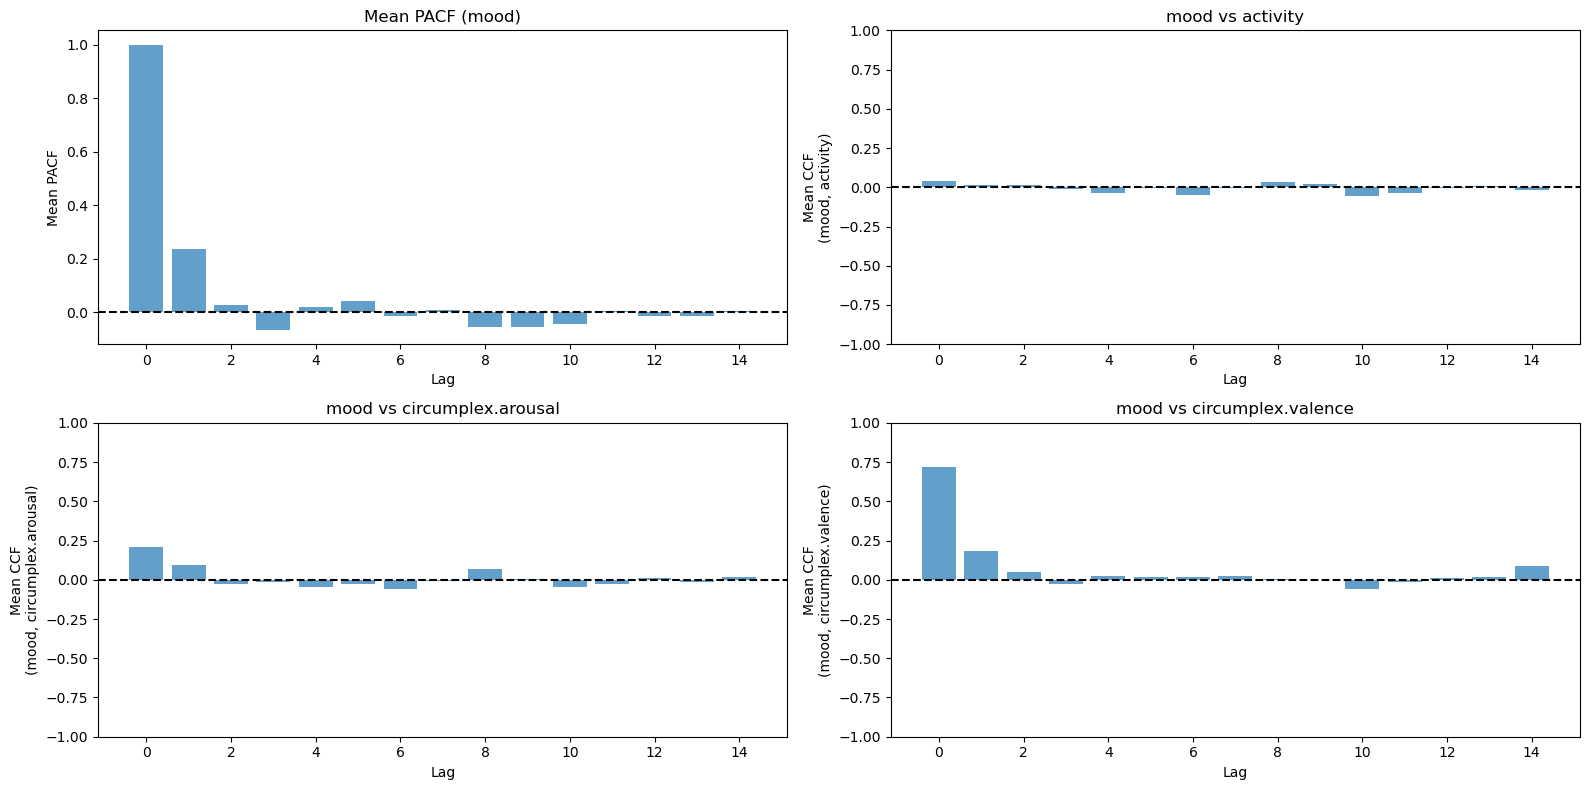

In [79]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
axs = axs.flatten()

# First plot: PACF
plot_mean_pacf(daily_mood, ax=axs[0])

# Next plots: CCFs
ccf_vars = [
    ('mood', 'activity'),
    ('mood', 'circumplex.arousal'),
    ('mood', 'circumplex.valence'),
]

for i, (var1, var2) in enumerate(ccf_vars):
    plot_mean_ccf(daily_mood, var1=var1, var2=var2, max_lag=14, ax=axs[i+1])

plt.tight_layout()
plt.savefig('plots/pacf_ccf_per_user.png')
plt.show()
